In [3]:
# --- Imports ---
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
import joblib
import ipywidgets as widgets
from IPython.display import display, clear_output

In [4]:
# --- Load Dataset ---
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
filename = "sms.tsv"
urllib.request.urlretrieve(url, filename)

df = pd.read_csv(filename, sep='\t', header=None, names=['label', 'message'])
print(f"Dataset size: {df.shape}")
df.head()

Dataset size: (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# --- Clean and Prepare Data ---
df['label'] = df['label'].str.lower().str.strip()
df = df[df['label'].isin(['ham', 'spam'])].reset_index(drop=True)
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

custom_stopwords = {'u', 'ur', '4', '2', 'im', 'dont', 'd'}
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stopwords))

vectorizer = TfidfVectorizer(stop_words=stop_words, lowercase=True, ngram_range=(1,2))
X = vectorizer.fit_transform(df['message'])
y = df['label_num'].values

print("Class distribution:\n", df['label'].value_counts())

Class distribution:
 label
ham     4825
spam     747
Name: count, dtype: int64


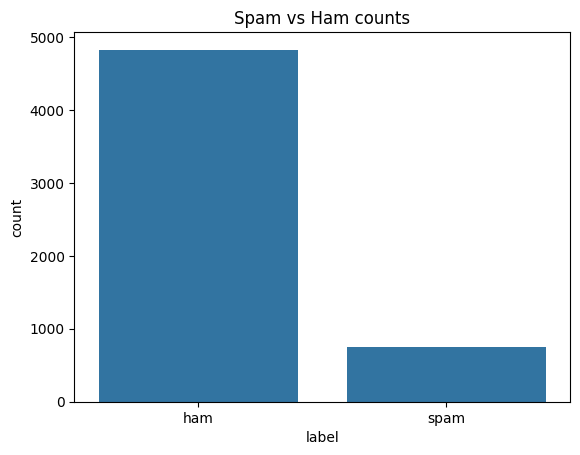

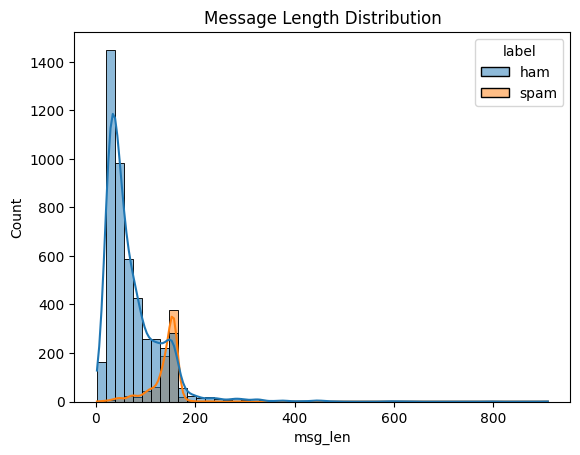

In [6]:
# --- Exploratory Data Analysis ---
sns.countplot(x='label', data=df)
plt.title('Spam vs Ham counts')
plt.show()

df['msg_len'] = df['message'].str.len()
sns.histplot(data=df, x='msg_len', hue='label', bins=50, kde=True)
plt.title('Message Length Distribution')
plt.show()

In [7]:
# --- Define Dynamic Parameters for Preprocessing & Vectorization ---
# You can change these anytime to experiment

custom_stopwords = {'u', 'ur', '4', '2', 'im', 'dont', 'd'}
use_custom_stopwords = True  # Set False if you want only default English stopwords

ngram_min = 1
ngram_max = 2
max_features = 10000  # limit vocab size for performance

threshold_default = 0.5  # initial spam detection threshold

# Prepare stop words set dynamically
if use_custom_stopwords:
    stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stopwords))
else:
    stop_words = 'english'

print(f"Stop words: {'Custom + English' if use_custom_stopwords else 'English only'}")
print(f"N-gram range: ({ngram_min}, {ngram_max})")
print(f"Max features: {max_features}")

Stop words: Custom + English
N-gram range: (1, 2)
Max features: 10000


In [8]:
# --- Vectorization ---
vectorizer = TfidfVectorizer(
    stop_words=stop_words,
    lowercase=True,
    ngram_range=(ngram_min, ngram_max),
    max_features=max_features
)

X = vectorizer.fit_transform(df['message'])
y = df['label_num'].values

In [9]:
# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

Train size: 4457, Test size: 1115


In [10]:
# --- Train Logistic Regression Model ---
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       966
           1       1.00      0.64      0.78       149

    accuracy                           0.95      1115
   macro avg       0.97      0.82      0.88      1115
weighted avg       0.95      0.95      0.95      1115



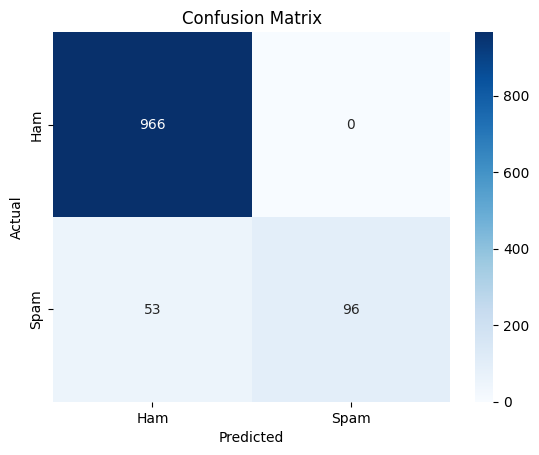

In [11]:
# --- Evaluate Model with Default Threshold ---
y_pred = model.predict(X_test)

print("Classification Report (threshold=0.5):")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# --- Fine-Tune Threshold Dynamically ---

# Calculate probabilities for test set
y_probs = model.predict_proba(X_test)[:, 1]

def find_best_threshold(probs, true_labels):
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_thresh = 0.5
    best_f1 = 0
    for thresh in thresholds:
        preds = (probs >= thresh).astype(int)
        score = f1_score(true_labels, preds)
        if score > best_f1:
            best_f1 = score
            best_thresh = thresh
    return best_thresh, best_f1

best_threshold, best_f1 = find_best_threshold(y_probs, y_test)
print(f"Best threshold found: {best_threshold:.2f} with F1-score: {best_f1:.3f}")

# Use the best threshold for final predictions
final_preds = (y_probs >= best_threshold).astype(int)
print("Classification report with best threshold:")
print(classification_report(y_test, final_preds))

Best threshold found: 0.25 with F1-score: 0.923
Classification report with best threshold:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       966
           1       0.96      0.89      0.92       149

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



Top spam words:
       feature      coef
9069      txt  4.442982
6131   mobile  3.537973
1879    claim  3.513600
9134       uk  3.486386
9839      www  3.364397
7461    reply  3.100611
8325     stop  3.067706
3948     free  2.996468
7851  service  2.933741
306      150p  2.702073
7142    prize  2.548523
8629     text  2.520429
1988      com  2.414965
9731      won  2.280083
571        50  2.235922

Top ham words:
      feature      coef
6626      ok -1.923407
5550      ll -1.685519
2305      da -1.499601
2001    come -1.491352
4303     got -1.443955
4402      gt -1.440182
5757      lt -1.425118
4726    home -1.412353
5639     lor -1.304296
8165   sorry -1.276035
5759   lt gt -1.239709
4642     hey -1.214154
4223   going -1.206042
4257    good -1.185261
5337   later -1.173825


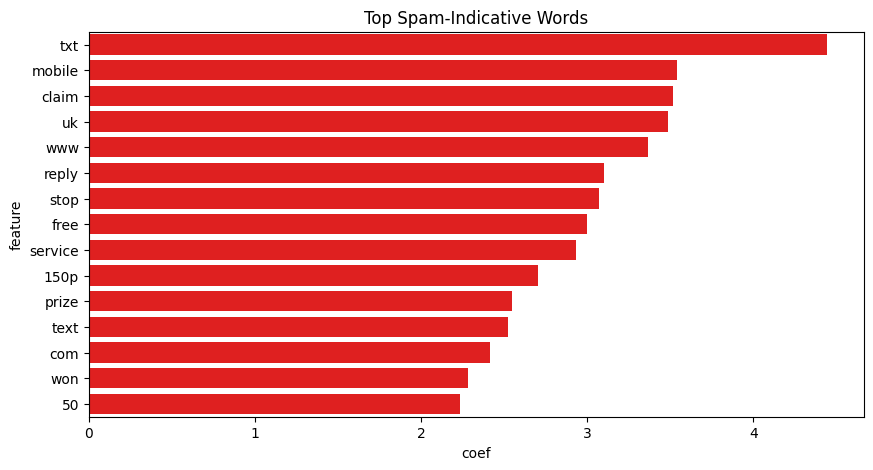

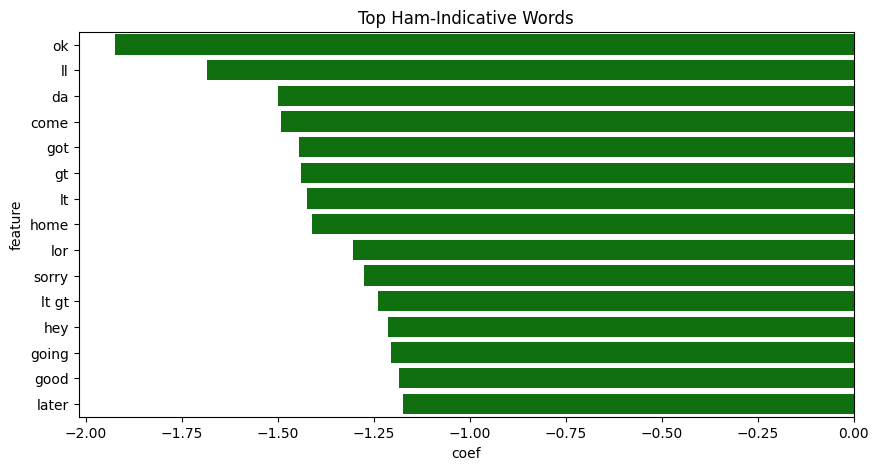

In [13]:
# --- Show Most Important Features ---

feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_[0]

feat_imp = pd.DataFrame({'feature': feature_names, 'coef': coefs})
top_spam = feat_imp.sort_values('coef', ascending=False).head(15)
top_ham = feat_imp.sort_values('coef').head(15)

print("Top spam words:\n", top_spam)
print("\nTop ham words:\n", top_ham)

plt.figure(figsize=(10, 5))
sns.barplot(x='coef', y='feature', data=top_spam, color='red')
plt.title('Top Spam-Indicative Words')
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x='coef', y='feature', data=top_ham, color='green')
plt.title('Top Ham-Indicative Words')
plt.show()

In [14]:
# --- Save Model and Vectorizer for Future Use ---
joblib.dump(model, 'spam_classifier_model.joblib')
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')
print("Saved model and vectorizer.")

Saved model and vectorizer.


In [15]:
# --- Interactive Testing Widget (with dynamic threshold) ---

import ipywidgets as widgets
from IPython.display import display, clear_output

input_box = widgets.Text(
    value='',
    placeholder='Type your message here...',
    description='Message:',
    layout=widgets.Layout(width='80%')
)

threshold_slider = widgets.FloatSlider(
    value=best_threshold,
    min=0.0,
    max=1.0,
    step=0.01,
    description='Spam Threshold:',
    continuous_update=False,
    layout=widgets.Layout(width='80%')
)

output = widgets.Output()

# Initialize empty DataFrame to log predictions
log_df = pd.DataFrame(columns=['message', 'spam_prob', 'ham_prob', 'prediction'])

def on_submit(change):
    with output:
        clear_output()
        msg = change['new']
        if not msg.strip():
            print("Please enter a non-empty message.")
            return

        # Vectorize the input message
        msg_vec = vectorizer.transform([msg])
        # Predict probabilities
        probs = model.predict_proba(msg_vec)[0]
        spam_prob = probs[1]
        ham_prob = probs[0]
        threshold = threshold_slider.value
        label = 'Spam' if spam_prob >= threshold else 'Ham'
        color = 'red' if label == 'Spam' else 'green'

        global log_df
        # Create a new row as DataFrame
        new_row = pd.DataFrame({
            'message': [msg],
            'spam_prob': [spam_prob],
            'ham_prob': [ham_prob],
            'prediction': [label]
        })
        # Concatenate to log_df
        log_df = pd.concat([log_df, new_row], ignore_index=True)

        print(f"Spam probability: {spam_prob:.3f}")
        print(f"Ham probability: {ham_prob:.3f}")
        display(widgets.HTML(f"<b style='color:{color}; font-size:16px;'>Prediction: {label}</b>"))

        print("\n--- Last 5 Messages ---")
        display(log_df.tail(5))

input_box.observe(on_submit, names='value')

export_button = widgets.Button(description='Export Log as CSV')

def export_log(b):
    if log_df.empty:
        print("No messages logged yet.")
        return
    log_df.to_csv('spam_predictions_log.csv', index=False)
    print("Log exported to spam_predictions_log.csv")

export_button.on_click(export_log)

display(input_box, threshold_slider, output, export_button)


Text(value='', description='Message:', layout=Layout(width='80%'), placeholder='Type your message here...')

FloatSlider(value=0.25000000000000006, continuous_update=False, description='Spam Threshold:', layout=Layout(w…

Output()

Button(description='Export Log as CSV', style=ButtonStyle())